# Data Augmentation

In [1]:
pip install timer

In [59]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np

from torchvision.transforms import v2 as T
import torch.nn.functional as F

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Subset
from timeit import default_timer as timer
from torchsummary import summary
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [60]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Import a dataset

In [66]:
# transformations
transform = T.Compose([ T.ToTensor(),
                        T.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5])
                       ])

# import the data and simultaneously apply the transform
train_data = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform)
dev_test_data  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

dev_test_data_len = len(dev_test_data)
VAL_SPLIT = int(dev_test_data_len * 0.3)
TEST_SPLIT = int(dev_test_data_len * 0.7)

randidx = np.random.permutation(dev_test_data_len)
val_data  = Subset(dev_test_data, randidx[:VAL_SPLIT])
test_data = Subset(dev_test_data, randidx[VAL_SPLIT:])

# transform to dataloaders
BATCH_SIZE       = 128
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader   = DataLoader(val_data)
test_dataloader  = DataLoader(test_data)

In [67]:
# check out the shape of the datasets
print('Data shapes (train/dev/test):')
print( len(train_data) )
print( len(val_data) )
print( len(test_data) )

# and the range of pixel intensity values
print('\nData value range:')
print( (np.min(train_data.data),np.max(train_data.data)) )

# the unique categories
print('\nData categories:')
print( train_data.classes )
print( len(train_data.classes) )

Data shapes (train/dev/test):
50000
3000
7000

Data value range:
(np.uint8(0), np.uint8(255))

Data categories:
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
10


In [68]:
X,y = next(iter(train_dataloader))

print('Data shapes (train/test):')
print( X.data.shape )

print('\nData value range:')
print( (torch.min(X.data),torch.max(X.data)) )

Data shapes (train/test):
torch.Size([128, 3, 32, 32])

Data value range:
(tensor(-1.), tensor(1.))


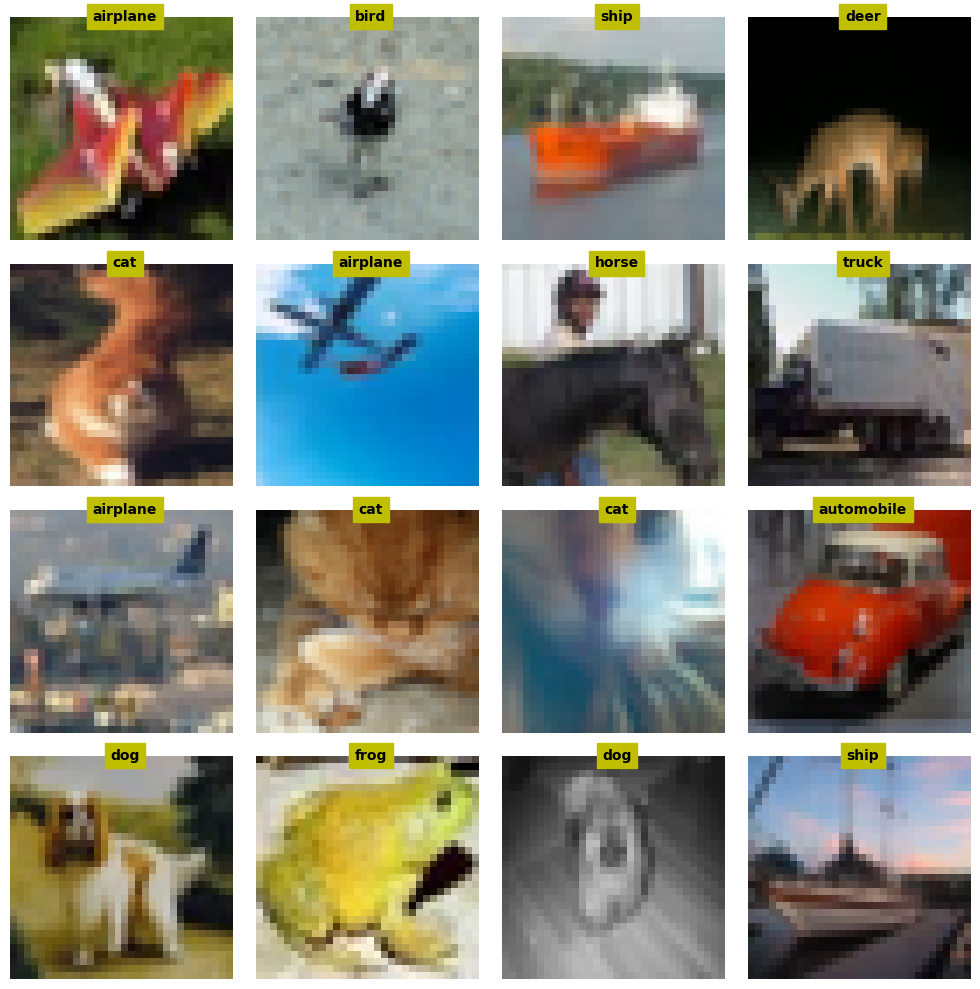

In [69]:
# inspect a few random images

fig,axs = plt.subplots(4, 4,figsize=(10, 10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 32x32x3)
  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization

  # and its label
  label = train_data.classes[y[i]]

  # and show!
  ax.imshow(pic)
  ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [70]:
def train_step(model, data_loader, loss_fn, optimizer, device):

    model.train()

    train_loss, train_acc = 0, 0

    for X, y in data_loader:
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    return train_loss / len(data_loader), train_acc / len(data_loader)


def test_step(model, data_loader, loss_fn, device):

    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for X, y in data_loader:

            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            test_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    return test_loss / len(data_loader), test_acc / len(data_loader)

def train(model,
          train_data_loader,
          test_data_loader,
          optimizer,
          loss_fn,
          epochs,
          device):

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
        }

    model.to(device)

    for epoch in tqdm(range(epochs)):

        start_time = timer()
        train_loss, train_acc = train_step(
            model=model,
            data_loader=train_data_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
        )
        end_time = timer()

        test_loss, test_acc = test_step(
            model=model,
            data_loader=test_data_loader,
            loss_fn=loss_fn,
            device=device,
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f} | "
            f"time: {(end_time-start_time):.4f}"
        )

    return results

def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [71]:
class CNN(nn.Module):
    def __init__(self, in_channels = 3, output_shape = 10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels=32, kernel_size=(3, 3), stride=2)
        # (32 - 3) / 2 +1 = 15
        # [batch_size, 32, 15, 15]
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels=64, kernel_size=(3, 3), stride=2)
        # (15 - 3) / 2 +1 = 7
        # [batch_size, 64, 7, 7]
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels=128, kernel_size=(3, 3), stride=2)
        # (7 - 3) / 2 +1 = 3
        # [batch_size, 128, 3, 3]

        self.linear_layers = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(in_features=128 * 3 * 3, out_features=1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=1024, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.linear_layers(x)
        return x

In [72]:
model_0 = CNN().to(device)
next(model_0.parameters()).device

device(type='cuda', index=0)

In [73]:
summary(model_0.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 15, 15]             896
            Conv2d-2             [-1, 64, 7, 7]          18,496
            Conv2d-3            [-1, 128, 3, 3]          73,856
           Flatten-4                 [-1, 1152]               0
           Dropout-5                 [-1, 1152]               0
            Linear-6                 [-1, 1024]       1,180,672
              ReLU-7                 [-1, 1024]               0
           Dropout-8                 [-1, 1024]               0
            Linear-9                   [-1, 10]          10,250
Total params: 1,284,170
Trainable params: 1,284,170
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.13
Params size (MB): 4.90
Estimated Total Size (MB): 5.04
---------------------------------------

In [74]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.0001)

In [75]:
results = train(
    model=model_0,
    train_data_loader=train_dataloader,
    test_data_loader=val_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device,
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9049 | train_acc: 31.4882 | test_loss: 1.6530 | test_acc: 40.2000 | time: 18.2814
Epoch: 2 | train_loss: 1.5781 | train_acc: 43.1338 | test_loss: 1.4844 | test_acc: 46.2333 | time: 12.9893
Epoch: 3 | train_loss: 1.4789 | train_acc: 46.7032 | test_loss: 1.4252 | test_acc: 49.0333 | time: 15.9046
Epoch: 4 | train_loss: 1.4162 | train_acc: 48.9510 | test_loss: 1.3702 | test_acc: 50.7667 | time: 13.7160
Epoch: 5 | train_loss: 1.3628 | train_acc: 50.9051 | test_loss: 1.3266 | test_acc: 51.9667 | time: 13.0688
Epoch: 6 | train_loss: 1.3233 | train_acc: 52.4628 | test_loss: 1.2900 | test_acc: 52.9000 | time: 13.2759
Epoch: 7 | train_loss: 1.2825 | train_acc: 54.1600 | test_loss: 1.2489 | test_acc: 54.2333 | time: 13.3905
Epoch: 8 | train_loss: 1.2488 | train_acc: 55.4608 | test_loss: 1.2243 | test_acc: 55.8667 | time: 14.2390
Epoch: 9 | train_loss: 1.2194 | train_acc: 56.6640 | test_loss: 1.1949 | test_acc: 56.5000 | time: 13.1110
Epoch: 10 | train_loss: 1.1918 | trai

In [ ]:
# epoch 4 acc: 54.8667

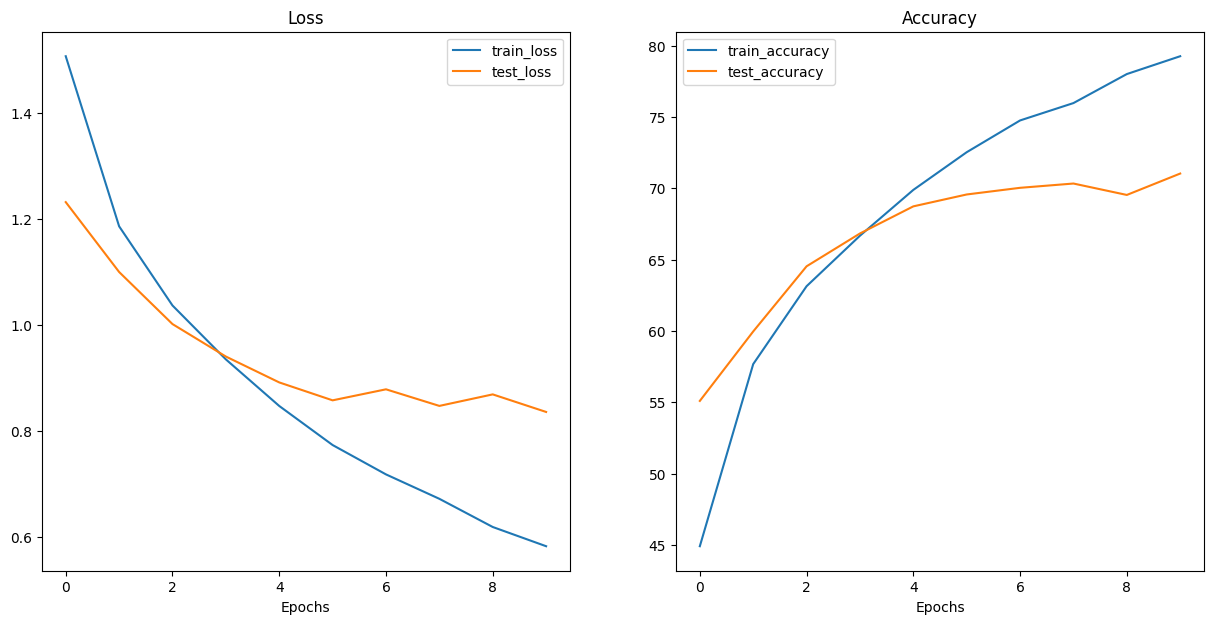

In [ ]:
plot_loss_curves(results)

In [ ]:
test_step(model=model_0, data_loader=test_dataloader, loss_fn=loss_fn, device=device)

(0.8209450216551583, 72.35714285714286)

In [ ]:
pip install torchmetrics mlxtend

In [ ]:
def get_preds_and_trues(model, data_loader, device):

    model.eval()


    y_preds = []
    y_true = []

    with torch.inference_mode():
        for X, y in data_loader:

            X = X.to(device)

            y_pred = model(X)

            y_pred = torch.softmax(y_pred, dim=1).argmax(dim=1)
            y_preds.append(y_pred.cpu())
            y_true.append(y.cpu())

    return torch.cat(y_preds), torch.cat(y_true)

In [ ]:
y_preds, y_true = get_preds_and_trues(model_0, test_dataloader, device)

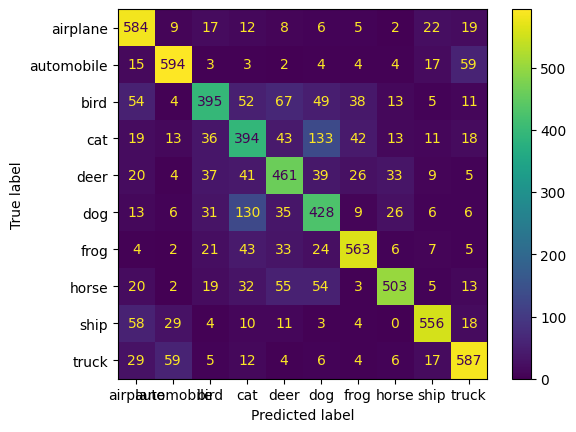

In [ ]:
cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=train_data.classes)
disp.plot()

In [ ]:
transform2 = T.Compose([
                        T.RandomCrop(32, padding=4),
                        # T.ColorJitter(brightness=0.3, contrast=0.3, hue=0.3),
                        T.RandomHorizontalFlip(p=0.5),
                        # T.RandomRotation(degrees=25),
                        # T.RandomAffine(degrees=5, translate=(0.1,0.1))
                        # T.RandomPerspective(degrees=25),
                        T.ToTensor(),
                        T.Normalize([.5,.5,.5],[.5,.5,.5])
                       ])

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
train_data = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform2)
dev_test_data  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

dev_test_data_len = len(dev_test_data)
VAL_SPLIT = int(dev_test_data_len * 0.3)
TEST_SPLIT = int(dev_test_data_len * 0.7)

randidx = np.random.permutation(dev_test_data_len)
val_data  = Subset(dev_test_data,randidx[:VAL_SPLIT])
test_data = Subset(dev_test_data,randidx[VAL_SPLIT:])

# transform to dataloaders
BATCH_SIZE    = 32
train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
val_dataloader   = DataLoader(val_data,  batch_size=BATCH_SIZE)
test_dataloader  = DataLoader(test_data, batch_size=BATCH_SIZE)

In [ ]:
class CNN2(nn.Module):
    def __init__(self, in_channels = 3, output_shape = 10):
        super().__init__()

        # x.shape: [n_samples, n_channels=3, H=32, W=32]

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels = 32, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2)
        )

        # x.shape: ???

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels = 64, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)
        )

        # x.shape: ???

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels = 128, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )

        # x.shape: ???

        self.linear_layers = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(in_features=128 * 4 * 4, out_features=1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=1024, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.linear_layers(x)
        return x

In [ ]:
model_1 = CNN2().to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [ ]:
summary(model_1.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
              ReLU-9           [-1, 64, 16, 16]               0
      BatchNorm2d-10           [-1, 64, 16, 16]             128
           Conv2d-11           [-1, 64, 16, 16]          36,928
             ReLU-12           [-1, 64, 16, 16]               0
      BatchNorm2d-13           [-1, 64, 16, 16]             128
        MaxPool2d-14             [-1, 6

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

In [ ]:
results = train(
    model=model_1,
    train_data_loader=train_dataloader,
    test_data_loader=val_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=30,
    device=device,
)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3919 | train_acc: 50.2159 | test_loss: 0.9887 | test_acc: 64.6720 | time: 40.9045
Epoch: 2 | train_loss: 0.9860 | train_acc: 65.5590 | test_loss: 0.8169 | test_acc: 72.1188 | time: 32.3311
Epoch: 3 | train_loss: 0.8474 | train_acc: 70.9293 | test_loss: 0.6970 | test_acc: 75.6095 | time: 33.2741
Epoch: 4 | train_loss: 0.7540 | train_acc: 74.3942 | test_loss: 0.6414 | test_acc: 78.3466 | time: 31.9477
Epoch: 5 | train_loss: 0.6811 | train_acc: 76.7814 | test_loss: 0.5953 | test_acc: 79.5434 | time: 31.8647
Epoch: 6 | train_loss: 0.6341 | train_acc: 78.6348 | test_loss: 0.5703 | test_acc: 80.5186 | time: 31.9045
Epoch: 7 | train_loss: 0.5929 | train_acc: 80.1504 | test_loss: 0.5560 | test_acc: 80.7957 | time: 31.4844
Epoch: 8 | train_loss: 0.5579 | train_acc: 81.2060 | test_loss: 0.5076 | test_acc: 82.5022 | time: 32.9286
Epoch: 9 | train_loss: 0.5268 | train_acc: 82.2577 | test_loss: 0.4664 | test_acc: 83.6215 | time: 32.0330
Epoch: 10 | train_loss: 0.5007 | trai

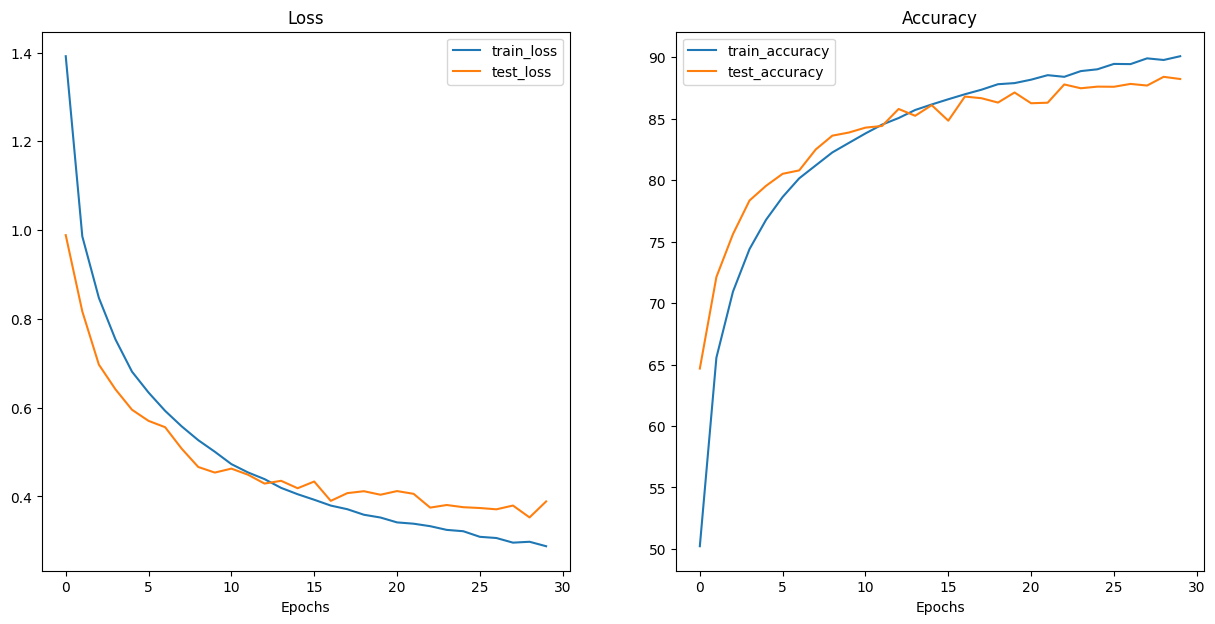

In [ ]:
plot_loss_curves(results)

In [ ]:
test_step(model=model_1, data_loader=test_dataloader, loss_fn=loss_fn, device=device)

(0.3642212952738075, 88.57971841704718)

In [ ]:
y_preds, y_true = get_preds_and_trues(model_1, test_dataloader, device)

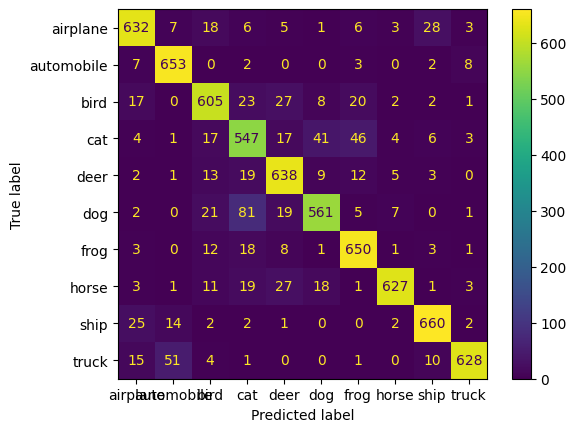

In [ ]:
cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=train_data.classes)
disp.plot()